In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from aif360.datasets import AdultDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    balanced_accuracy_score,
    confusion_matrix
 )

from IPython.display import Markdown, display
import seaborn as sns

%matplotlib inline


In [354]:
# custom processing for the dataset
def custom_preprocessing(df):
    """Binarize age, encode race/sex, and drop raw columns to expose protected attributes explicitly."""
    median_age = df['age'].median()
    df['age_binary'] = (df['age'] > median_age).astype(float)
    df.drop(columns=['age'], inplace=True)
    df['race'] = (df['race'] == 'White').astype(float)
    df['sex'] = (df['sex'] == 'Male').astype(float)
    return df

dataset = AdultDataset(custom_preprocessing=custom_preprocessing,
                              protected_attribute_names=['age_binary', 'sex'],
                              privileged_classes=[np.array([1.0]), np.array([1.0])] ) # old white males

In [355]:
# privileged and unprivileged groups
privileged_groups = [{'sex': 1, 'age_binary': 1}] # old white males
unprivileged_groups = [{'sex': 0, 'age_binary': 0}]

## Private + Fair Classifier

Now we will apply the same fairness mitigation technique (Reweighing) to the privatized dataset to create a **private+fair classifier**. This combines both privacy protection (via differential privacy) and fairness mitigation (via reweighing).

### Approach:
1. Create privatized dataset with differential privacy (ε = 1.0)
2. Apply Reweighing to the privatized training data
3. Train classifier on reweighed private data
4. As an auditor with access to **real** Age and Sex values, measure fairness
5. Compare private+fair vs fair classifier fairness metrics

In [356]:

sns.set_theme(style="whitegrid")

# Apply differential privacy to age and sex
k = 4  # Number of categories
epsilon = 1.0  # Balanced privacy level

def dp_randomized_response(categories, epsilon, k=4):
    """Implements the randomized response mechanism for differential privacy."""
    categories = np.asarray(categories, dtype=int)
    n = len(categories)
    
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)  # Probability of truth
    q = (1.0 - p) / (k - 1)  # Probability of each lie
    
    reports = np.empty_like(categories)
    u = np.random.rand(n)
    same = (u < p)
    
    reports[same] = categories[same]
    
    num_flip = np.sum(~same)
    if num_flip > 0:
        true_vals = categories[~same]
        alt = np.random.randint(0, k-1, size=num_flip)
        alt += (alt >= true_vals).astype(int)
        reports[~same] = alt
    
    return reports, p, q

"""
To apply differential privacy efficiently, we'll combine age and sex into a single categorical variable with 4 possible values. 
This allows us to use the randomized response mechanism.
Combined categories explanation:
Category 0: Young Female (≤38 years, female)
Category 1: Young Male   (≤38 years, male)")
Category 2: Older Female (>38 years, female)
Category 3: Older Male   (>38 years, male)
"""
df_full = dataset.convert_to_dataframe()[0]
df_full['age_sex_cat'] = df_full['age_binary'] * 2 + df_full['sex']

# Apply differential privacy
np.random.seed(42)  # For reproducibility
reports, p, q = dp_randomized_response(df_full['age_sex_cat'].values, epsilon, k)

print(f"Differential Privacy Applied (ε = {epsilon})")
print(f"Truth probability: {p:.1%}")
print(f"Lie probability: {(1-p):.1%}")

print(reports)

# Extract privatized age and sex
age_binary_private = (reports // 2).astype(float)
sex_binary_private = (reports % 2).astype(float)

print(f"Original Age_binary distribution: {np.bincount(df_full['age_binary'].astype(int))}")
print(f"Private Age_binary distribution:  {np.bincount(age_binary_private.astype(int))}")
print(f"Original Sex distribution: {np.bincount(df_full['sex'].astype(int))}")
print(f"Private Sex distribution:  {np.bincount(sex_binary_private.astype(int))}")

Differential Privacy Applied (ε = 1.0)
Truth probability: 47.5%
Lie probability: 52.5%
[1 1 3 ... 2 1 0]
Original Age_binary distribution: [23027 22195]
Private Age_binary distribution:  [22617 22605]
Original Sex distribution: [14695 30527]
Private Sex distribution:  [20362 24860]


In [357]:
# Get all features except age_binary and sex, since we will replace them with their differentially private versions
feature_names_without_protected = [f for f in dataset.feature_names if f not in ['age_binary', 'sex']]
features_other = df_full[feature_names_without_protected].values # numpy array

# Combine other features with PRIVATE age_binary and sex
features_private = np.column_stack([
    features_other,
    age_binary_private,
    sex_binary_private
])

# Reconstruct feature names with private attributes at the end
feature_names_private = feature_names_without_protected + ['age_binary', 'sex']

# Create BinaryLabelDataset with PRIVATE attributes
dataset_private = BinaryLabelDataset(
    favorable_label=1.0, # Income > 50k is the "favorable" outcome
    unfavorable_label=0.0, #  Income =<50k is the "unfavorable" outcome
    df=pd.DataFrame(
        np.column_stack([features_private, dataset.labels]),
        columns=feature_names_private + ['income-per-year']
    ),
    label_names=['income-per-year'],
    protected_attribute_names=['age_binary', 'sex']
)

# we need to specify them because the BinaryLabelDataset doesn't accept the privileged_classes
dataset_private.privileged_protected_attributes = [np.array([1.0]), np.array([1.0])]
dataset_private.unprivileged_protected_attributes = [np.array([0.0]), np.array([0.0])]

print("Private dataset created successfully")
print(f"Shape: {dataset_private.features.shape}")
print(f"Protected attributes: {dataset_private.protected_attribute_names}")

Private dataset created successfully
Shape: (45222, 98)
Protected attributes: ['age_binary', 'sex']


In [358]:
np.random.seed(1)
dataset_private_train, dataset_private_vt = dataset_private.split([0.7], shuffle=True)
dataset_private_valid, dataset_private_test = dataset_private_vt.split([0.5], shuffle=True)

print(f"Private training set: {dataset_private_train.features.shape[0]} samples")
print(f"Private validation set: {dataset_private_valid.features.shape[0]} samples")
print(f"Private test set: {dataset_private_test.features.shape[0]} samples")

Private training set: 31655 samples
Private validation set: 6783 samples
Private test set: 6784 samples


In [359]:
# Check fairness metrics on PRIVATE dataset BEFORE reweighing
metric_private_train = BinaryLabelDatasetMetric(
    dataset_private_train, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

display(Markdown("#### Private training dataset (BEFORE reweighing)"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_private_train.mean_difference())

#### Private training dataset (BEFORE reweighing)

Difference in mean outcomes between unprivileged and privileged groups = -0.110772


In [360]:
#Apply Reweighing to the PRIVATE training dataset
RW_private = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
dataset_private_transf_train = RW_private.fit_transform(dataset_private_train)


In [361]:
# Check fairness metrics AFTER reweighing
metric_private_transf_train = BinaryLabelDatasetMetric(
    dataset_private_transf_train, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

display(Markdown("#### Private training dataset (AFTER reweighing)"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_private_transf_train.mean_difference())

#### Private training dataset (AFTER reweighing)

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [362]:
# Train classifier on reweighed PRIVATE data (Private+Fair classifier)
def extract_xy(dataset):
    """Return numpy arrays of features and flattened labels """
    return dataset.features, dataset.labels.ravel()

X_train_private_transf, y_train_private_transf = extract_xy(dataset_private_transf_train)
X_test_private, y_test_private = extract_xy(dataset_private_test)

w_train_private_transf = dataset_private_transf_train.instance_weights

scaler_private = StandardScaler()
X_train_private_transf_scaled = scaler_private.fit_transform(X_train_private_transf)
X_test_private_scaled = scaler_private.transform(X_test_private)

lr_classifier_private_fair = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier_private_fair.fit(
    X_train_private_transf_scaled, 
    y_train_private_transf,
    sample_weight=w_train_private_transf
)

y_test_private_fair_pred = lr_classifier_private_fair.predict(X_test_private_scaled)

print("Private+Fair Classifier trained successfully!")

Private+Fair Classifier trained successfully!


## Auditor Evaluation: Using REAL Age and Sex Values

As an auditor, we have access to the **real (original) sensitive attributes** of Age and Sex. We will now evaluate the fairness of both classifiers using these true values, not the privatized ones.

This is a crucial distinction:
- The **private+fair classifier** was trained on noisy/privatized age and sex
- But we **evaluate** its fairness using the **true** age and sex values
- This shows whether the privacy protection inadvertently introduced or removed bias

In [ ]:
# We need to reconstruct the original test set to align with our private test split

# Recreate the original dataset split to get corresponding real values
np.random.seed(1)  # Same seed as used for private split
dataset_orig_train_audit, dataset_orig_vt_audit = dataset.split([0.7], shuffle=True)
dataset_orig_valid_audit, dataset_orig_test_audit = dataset_orig_vt_audit.split([0.5], shuffle=True)

print("Original test set for auditing created")
print(f"Original test set size: {dataset_orig_test_audit.features.shape[0]} samples")
print(f"Private test set size: {dataset_private_test.features.shape[0]} samples")

Original test set for auditing created
Original test set size: 6784 samples
Private test set size: 6784 samples


In [364]:
# Train the FAIR classifier for comparison

RW_original = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
dataset_orig_transf_train = RW_original.fit_transform(dataset_orig_train_audit)

X_train_orig_transf, y_train_orig_transf = extract_xy(dataset_orig_transf_train)
w_train_orig_transf = dataset_orig_transf_train.instance_weights

scaler_original = StandardScaler()
X_train_orig_transf_scaled = scaler_original.fit_transform(X_train_orig_transf)

X_test_orig, y_test_orig = extract_xy(dataset_orig_test_audit)
X_test_orig_scaled = scaler_original.transform(X_test_orig)

lr_classifier_fair = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier_fair.fit(
    X_train_orig_transf_scaled,
    y_train_orig_transf,
    sample_weight=w_train_orig_transf
)

y_test_fair_pred = lr_classifier_fair.predict(X_test_orig_scaled)

print("Fair Classifier")
print(f"Test accuracy: {accuracy_score(y_test_orig, y_test_fair_pred):.4f}")

Fair Classifier
Test accuracy: 0.8325


In [365]:
# Evaluate BOTH classifiers using REAL age and sex values

# For Fair classifier
dataset_fair_test_pred = dataset_orig_test_audit.copy()
dataset_fair_test_pred.labels = y_test_fair_pred

# For Private+Fair classifier
dataset_private_fair_test_pred = dataset_orig_test_audit.copy()
dataset_private_fair_test_pred.labels = y_test_private_fair_pred

In [366]:
# Calculate fairness metrics using REAL protected attributes
def summarize_fairness_metrics(metric):
    """Collect commonly used fairness metrics from an AIF360 ClassificationMetric object."""
    return {
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Disparate Impact": metric.disparate_impact(),
        "Average Odds Difference": metric.average_odds_difference(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Balanced Accuracy": 0.5 * (metric.true_positive_rate() + metric.true_negative_rate())
    }

# Fairness metrics for FAIR classifier (evaluated with real attributes)
metric_fair_test = ClassificationMetric(
    dataset_orig_test_audit,
    dataset_fair_test_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
fairness_metrics_fair = summarize_fairness_metrics(metric_fair_test)

# Fairness metrics for PRIVATE+FAIR classifier (evaluated with real attributes)
metric_private_fair_test = ClassificationMetric(
    dataset_orig_test_audit,
    dataset_private_fair_test_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
fairness_metrics_private_fair = summarize_fairness_metrics(metric_private_fair_test)

print("="*70)
print("AUDITOR EVALUATION: Fairness Metrics Using REAL Age and Sex")
print("="*70)
print("\nFAIR Classifier (trained on original data with reweighing):")
for metric_name, value in fairness_metrics_fair.items():
    print(f"  {metric_name:35s}: {value:8.4f}")

print("\nPRIVATE+FAIR Classifier (trained on private data with reweighing):")
for metric_name, value in fairness_metrics_private_fair.items():
    print(f"  {metric_name:35s}: {value:8.4f}")

print("\n" + "="*70)
print("DIFFERENCE (Private+Fair - Fair):")
print("="*70)
for metric_name in fairness_metrics_fair.keys():
    diff = fairness_metrics_private_fair[metric_name] - fairness_metrics_fair[metric_name]
    print(f"  {metric_name:35s}: {diff:+8.4f}")

AUDITOR EVALUATION: Fairness Metrics Using REAL Age and Sex

FAIR Classifier (trained on original data with reweighing):
  Statistical Parity Difference      :  -0.1441
  Disparate Impact                   :   0.3931
  Average Odds Difference            :   0.1395
  Equal Opportunity Difference       :   0.3037
  Balanced Accuracy                  :   0.7197

PRIVATE+FAIR Classifier (trained on private data with reweighing):
  Statistical Parity Difference      :  -0.2792
  Disparate Impact                   :   0.1790
  Average Odds Difference            :  -0.0217
  Equal Opportunity Difference       :   0.0744
  Balanced Accuracy                  :   0.7630

DIFFERENCE (Private+Fair - Fair):
  Statistical Parity Difference      :  -0.1351
  Disparate Impact                   :  -0.2141
  Average Odds Difference            :  -0.1612
  Equal Opportunity Difference       :  -0.2293
  Balanced Accuracy                  :  +0.0433


In [367]:
# Compare classifier performance (accuracy, precision, recall, F1)
print("="*70)
print("CLASSIFIER PERFORMANCE COMPARISON")
print("="*70)

# Fair classifier performance
fair_accuracy = accuracy_score(y_test_orig, y_test_fair_pred)
fair_precision = precision_score(y_test_orig, y_test_fair_pred)
fair_recall = recall_score(y_test_orig, y_test_fair_pred)
fair_f1 = f1_score(y_test_orig, y_test_fair_pred)
fair_balanced_acc = balanced_accuracy_score(y_test_orig, y_test_fair_pred)

print("FAIR Classifier:")
print(f"  Accuracy:          {fair_accuracy:.4f}")
print(f"  Precision:         {fair_precision:.4f}")
print(f"  Recall:            {fair_recall:.4f}")
print(f"  F1-Score:          {fair_f1:.4f}")
print(f"  Balanced Accuracy: {fair_balanced_acc:.4f}")

# Private+Fair classifier performance (evaluated on same test set)
private_fair_accuracy = accuracy_score(y_test_orig, y_test_private_fair_pred)
private_fair_precision = precision_score(y_test_orig, y_test_private_fair_pred)
private_fair_recall = recall_score(y_test_orig, y_test_private_fair_pred)
private_fair_f1 = f1_score(y_test_orig, y_test_private_fair_pred)
private_fair_balanced_acc = balanced_accuracy_score(y_test_orig, y_test_private_fair_pred)

print("PRIVATE+FAIR Classifier:")
print(f"  Accuracy:          {private_fair_accuracy:.4f}")
print(f"  Precision:         {private_fair_precision:.4f}")
print(f"  Recall:            {private_fair_recall:.4f}")
print(f"  F1-Score:          {private_fair_f1:.4f}")
print(f"  Balanced Accuracy: {private_fair_balanced_acc:.4f}")

print("Performance Impact of Privacy:")
print(f"  Accuracy drop:          {fair_accuracy - private_fair_accuracy:+.4f}")
print(f"  Precision drop:         {fair_precision - private_fair_precision:+.4f}")
print(f"  Recall drop:            {fair_recall - private_fair_recall:+.4f}")
print(f"  F1-Score drop:          {fair_f1 - private_fair_f1:+.4f}")
print(f"  Balanced Accuracy drop: {fair_balanced_acc - private_fair_balanced_acc:+.4f}")

CLASSIFIER PERFORMANCE COMPARISON
FAIR Classifier:
  Accuracy:          0.8325
  Precision:         0.7561
  Recall:            0.4927
  F1-Score:          0.5966
  Balanced Accuracy: 0.7197
PRIVATE+FAIR Classifier:
  Accuracy:          0.8467
  Precision:         0.7439
  Recall:            0.5947
  F1-Score:          0.6610
  Balanced Accuracy: 0.7630
Performance Impact of Privacy:
  Accuracy drop:          -0.0142
  Precision drop:         +0.0121
  Recall drop:            -0.1021
  F1-Score drop:          -0.0644
  Balanced Accuracy drop: -0.0433


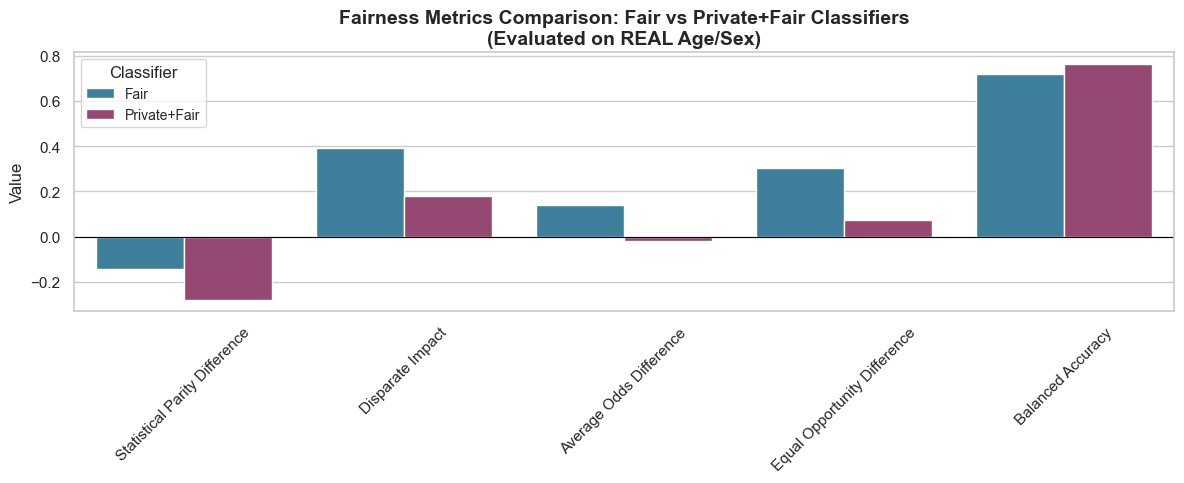

In [368]:
# Visualize fairness comparison
def plot_fairness_comparison(metrics_a, metrics_b, labels=("Fair", "Private+Fair")):
    """Plot side-by-side fairness metrics for two models to compare mitigation impact."""
    fairness_df = pd.DataFrame({
        "Metric": list(metrics_a.keys()) + list(metrics_b.keys()),
        "Value": list(metrics_a.values()) + list(metrics_b.values()),
        "Model": [labels[0]] * len(metrics_a) + [labels[1]] * len(metrics_b)
    })

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(data=fairness_df, x="Metric", y="Value", hue="Model", ax=ax, palette=["#2E86AB", "#A23B72"])
    ax.set_title("Fairness Metrics Comparison: Fair vs Private+Fair Classifiers\n(Evaluated on REAL Age/Sex)", 
                 fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_xlabel("")
    ax.axhline(0, color='black', linewidth=0.8)
    ax.legend(title="Classifier", fontsize=10)
    plt.tight_layout()
    plt.show()

plot_fairness_comparison(fairness_metrics_fair, fairness_metrics_private_fair)

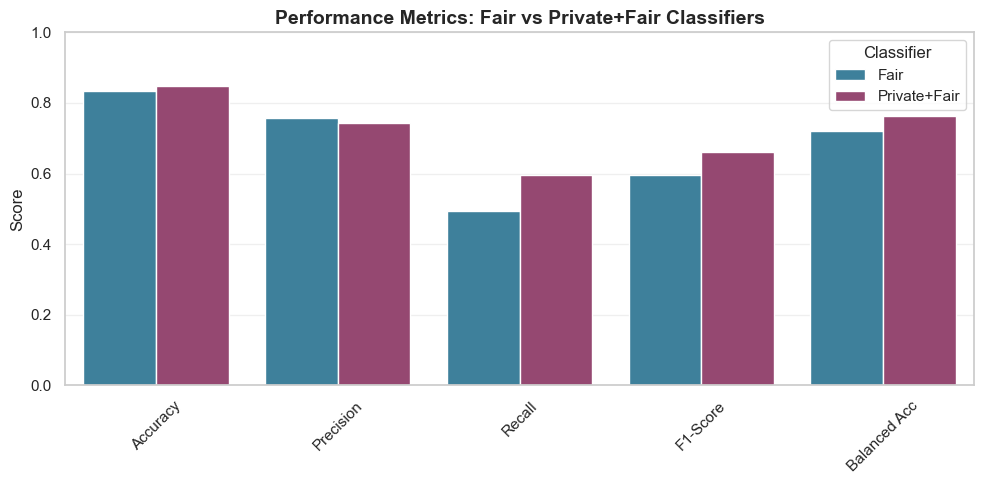

In [369]:
# Visualize performance metrics comparison
def plot_model_performance_comparison(metrics_fair, metrics_private_fair):
    """Visualize scalar performance metrics comparison between two classifiers."""
    
    metrics_comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Balanced Acc'],
        'Fair': [metrics_fair['accuracy'], metrics_fair['precision'], 
                 metrics_fair['recall'], metrics_fair['f1'], metrics_fair['balanced_acc']],
        'Private+Fair': [metrics_private_fair['accuracy'], metrics_private_fair['precision'],
                        metrics_private_fair['recall'], metrics_private_fair['f1'], 
                        metrics_private_fair['balanced_acc']]
    })
    
    # Reshape for seaborn
    metrics_melted = metrics_comparison.melt(id_vars=['Metric'], var_name='Classifier', value_name='Score')
    
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Classifier', ax=ax, palette=["#2E86AB", "#A23B72"])
    ax.set_ylim(0, 1)
    ax.set_title("Performance Metrics: Fair vs Private+Fair Classifiers", fontsize=14, fontweight='bold')
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Classifier")
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

metrics_fair_dict = {
    'accuracy': fair_accuracy,
    'precision': fair_precision,
    'recall': fair_recall,
    'f1': fair_f1,
    'balanced_acc': fair_balanced_acc
}

metrics_private_fair_dict = {
    'accuracy': private_fair_accuracy,
    'precision': private_fair_precision,
    'recall': private_fair_recall,
    'f1': private_fair_f1,
    'balanced_acc': private_fair_balanced_acc
}

plot_model_performance_comparison(metrics_fair_dict, metrics_private_fair_dict)

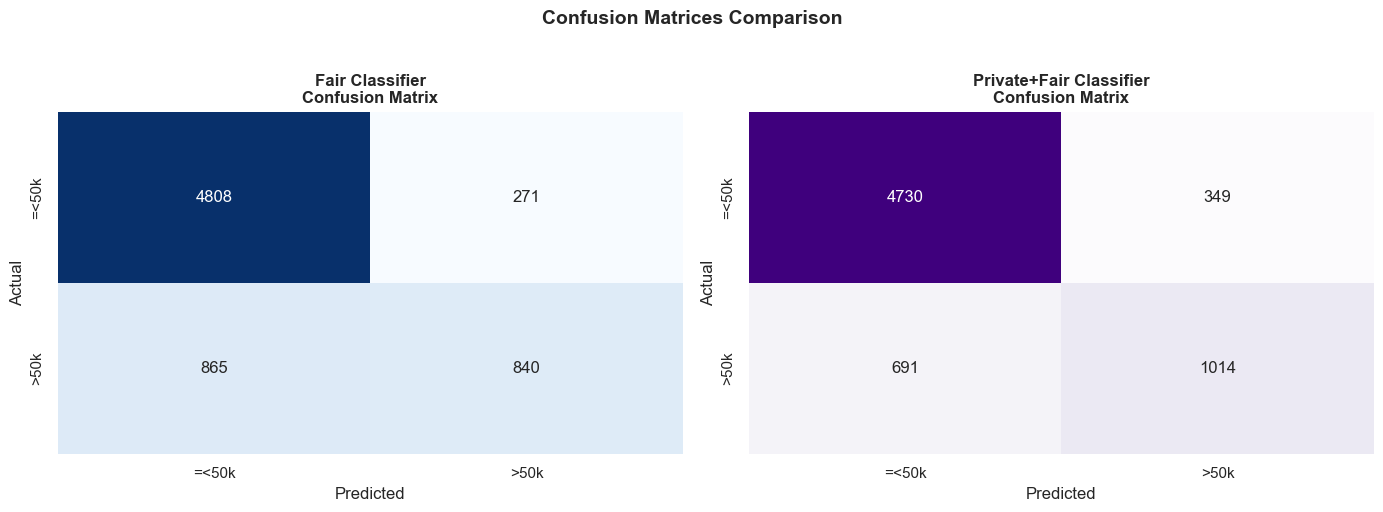

In [370]:
# Confusion matrices comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fair classifier confusion matrix
cm_fair = confusion_matrix(y_test_orig, y_test_fair_pred)
sns.heatmap(cm_fair, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['=<50k', '>50k'], yticklabels=['=<50k', '>50k'])
axes[0].set_title("Fair Classifier\nConfusion Matrix", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Private+Fair classifier confusion matrix
cm_private_fair = confusion_matrix(y_test_orig, y_test_private_fair_pred)
sns.heatmap(cm_private_fair, annot=True, fmt='d', cmap='Purples', cbar=False, ax=axes[1],
            xticklabels=['=<50k', '>50k'], yticklabels=['=<50k', '>50k'])
axes[1].set_title("Private+Fair Classifier\nConfusion Matrix", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.suptitle("Confusion Matrices Comparison", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()